<a href="https://colab.research.google.com/github/zappy586/Dr-Insights/blob/main/Mistral_MASHQA_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U transformers
!pip install -q -U xformers
!pip install -q -U peft
!pip install -q -U accelerate
!pip install -q -U datasets
!pip install -q -U trl
!pip install -q -U einops
!pip install -q -U nvidia-ml-py3
!pip install -q -U huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [ ]:
from datasets import load_dataset
dataset = load_dataset("ZappY-AI/MASHQA-JSON", split="train[:20%]")
dataset

Generating train split:   0%|          | 0/200035 [00:00<?, ? examples/s]

Dataset({
    features: ['question', 'answer'],
    num_rows: 40007
})

In [ ]:
def create_prompt(sample):
  system_prompt_template = """[INST]Act as a Multiple Answer Spans Healthcare Question Answering helpful assistant and answer the user's questions in details with reasoning. Do not give any false information. In case you don't have answer, specify why the question can't be answered.

### Question:
{question}

### Answer:
"""
  user_message = sample['question']
  user_response = sample['answer']
  prompt_template = system_prompt_template.replace("<<user_question>>",f"{user_message}").replace("<<user_response>>",f"{user_response}")

  return {"inputs":prompt_template}

#
instruct_tune_dataset = dataset.map(create_prompt)
print(instruct_tune_dataset)

Map:   0%|          | 0/40007 [00:00<?, ? examples/s]

Dataset({
    features: ['question', 'answer', 'inputs'],
    num_rows: 40007
})


In [ ]:
instruct_tune_dataset[0]

{'question': 'Jungkook is the 5th place. Find the number of people who crossed the finish line faster than Jungkook.',
 'answer': 'If Jungkook is in 5th place, then 4 people crossed the finish line faster than him.',
 'inputs': '<s>\nBelow is an instruction that describes a math problem.Write a response that appropriately and accurately solves the math problem.\n### Instruction :Jungkook is the 5th place. Find the number of people who crossed the finish line faster than Jungkook.\n### Response:\nIf Jungkook is in 5th place, then 4 people crossed the finish line faster than him.\n</s>\n'}

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from pynvml import *
from datasets import load_dataset
from trl import SFTTrainer
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
import time, torch

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

In [ ]:
base_model_id = "mistralai/Mistral-7B-v0.1"

#Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_eos_token=True, use_fast=True, max_length=250)
tokenizer.padding_side = 'right'
tokenizer.pad_token = tokenizer.eos_token

compute_dtype = getattr(torch, "float16") #change to bfloat16 if are using an Ampere (or more recent) GPU
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=True,
)
model = AutoModelForCausalLM.from_pretrained(
          base_model_id, trust_remote_code=True, quantization_config=bnb_config, revision="refs/pr/23", device_map={"": 0}, torch_dtype="auto", flash_attn=True, flash_rotary=True, fused_dense=True
)
print(print_gpu_utilization())

model = prepare_model_for_kbit_training(model)

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/2.03k [00:00<?, ?B/s]

modeling_phi.py:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/577M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


GPU memory occupied: 2168 MB.
None


In [ ]:
peft_config = LoraConfig(
        lora_alpha=16,
        lora_dropout=0.05,
        r=16,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules= ["Wqkv", "out_proj"])

In [ ]:
training_arguments = TrainingArguments(
        output_dir="./mistral-MASHQA-results2",
        save_strategy="epoch",
        per_device_train_batch_size=2,
        gradient_accumulation_steps=12,
        log_level="debug",
        save_steps=100,
        logging_steps=25,
        learning_rate=1e-4,
        eval_steps=50,
        optim='paged_adamw_8bit',
        fp16=True, #change to bf16 if are using an Ampere GPU
        num_train_epochs=3,
        max_steps=500,
        warmup_steps=100,
        lr_scheduler_type="linear",
        seed=42)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
train_dataset = instruct_tune_dataset.map(batched=True,remove_columns=['answer', 'question'])
train_dataset

Map:   0%|          | 0/40007 [00:00<?, ? examples/s]

Dataset({
    features: ['inputs'],
    num_rows: 40007
})

In [ ]:
trainer = SFTTrainer(
        model=model,
        train_dataset=train_dataset,
        #eval_dataset=dataset['test'],
        peft_config=peft_config,
        dataset_text_field="inputs",
        max_seq_length=512,
        tokenizer=tokenizer,
        args=training_arguments,
        packing=False
)


PyTorch: setting up devices
max_steps is given, it will override any value given in num_train_epochs
Using auto half precision backend


In [ ]:
trainer.train()

Currently training with a batch size of: 2
***** Running training *****
  Num examples = 40,007
  Num Epochs = 1
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 24
  Gradient Accumulation steps = 12
  Total optimization steps = 500
  Number of trainable parameters = 7,864,320


Step,Training Loss
25,1.148500
50,1.014700
75,0.714100
100,0.629700
125,0.604600
150,0.591100
175,0.582200
200,0.577200
225,0.574100
250,0.565000


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
from huggingface_hub import notebook_login

notebook_login()

trainer.push_to_hub(commit_message="fine-tuned adapter")

In [ ]:
# import torch
# torch.cuda.empty_cache()

In [ ]:
# import gc
# del model
# del tokenizer
# del trainer
# del train_dataset
# del peft_config
# del training_arguments
# gc.collect()

In [ ]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

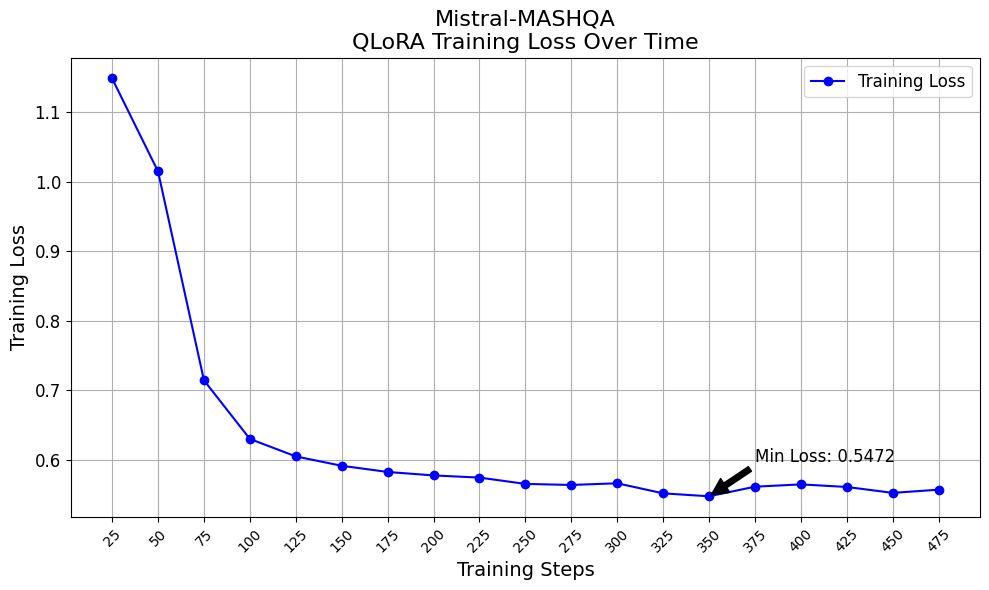

In [ ]:
import matplotlib.pyplot as plt

# Manually input the data from the provided metrics
steps = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475]
training_loss = [1.1485, 1.0147, 0.7141, 0.6297, 0.6046, 0.5911, 0.5822, 0.5772, 0.5741, 0.565, 0.5635, 0.5659, 0.5514, 0.5472, 0.561, 0.5643, 0.5606, 0.5521, 0.5567]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(steps, training_loss, marker='o', linestyle='-', color='b')

# Add title and labels
plt.title('Mistral-MASHQA\nQLoRA Training Loss Over Time', fontsize=16)
plt.xlabel('Training Steps', fontsize=14)
plt.ylabel('Training Loss', fontsize=14)

# Add grid for better readability
plt.grid(True)

# Customize ticks
plt.xticks(steps, rotation=45)
plt.yticks(fontsize=12)

# Add a legend
plt.legend(['Training Loss'], fontsize=12)

# Add annotation to indicate minimum loss
min_loss_index = training_loss.index(min(training_loss))
plt.annotate(f'Min Loss: {min(training_loss):.4f}', xy=(steps[min_loss_index], training_loss[min_loss_index]),
             xytext=(steps[min_loss_index] + 25, training_loss[min_loss_index] + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()